# Preço médio de carro no Brasil

Os dados deste dataset foram extraídos da FIPE, de 2021 até 2023.

Cada Linha corresponde a um preço médio de carro, calculado para um mês de um ano de referência. Em outras palavras, em um ano (year_of_reference) há 12 observações relacionadas ao mesmo carro, no entanto, o preço médio,avg_price_brl, pode variar.

**Features:**
- **year_of_reference**: ano de referência da observação, ou seja, o ano ao qual os dados correspondem.
- **month_of_reference**: mês de referência da observação, ou seja, o mês ao qual os dados correspondem. O preço médio é calculado pela FIPE a cada mês.
- **fipe_code**: ID único correspondente a um modelo para facilitar a pesquisa na página da FIPE.
- **authentication**: código único que autentica a consulta no site da FIPE.
- **brand**: marca do carro.
- **model**: uma descrição do carro contendo o nome e outras informações descritivas, conforme fornecido na tabela da FIPE.
- **fuel**: combustível usado pelo carro. Alguns carros a gasolina são, na verdade, álcool e gasolina (totalflex), o que é comum no Brasil.
- **gear**: o modo como as marchas são trocadas.
- **engine_size**: Cilindrada o motor.
- **year_model**: esses valores correspondem ao ano de referência e podem não ser os mesmos do ano de fabricação, que nesse caso corresponderá a um ano anterior ao **year_model**. Observações com **year_model** = **year_of_reference** significam que o carro é novo naquele ano de referência, ou seja, um carro de 2021 com **year_of_reference** = 2021 e **month_of_reference** = julho significa que a observação (principalmente o preço médio) corresponde a um carro novo no ano de 2021, no mês de julho. O mesmo modelo pode ter um preço médio diferente para diferentes meses.
- **avg_price_brl**: preço médio do carro, conforme medido pela FIPE, em BRL.

# Objetivos:
- Compreender como esse Dataset é estruturado
- Extrair informações para auxiliar na tomada de decisão
- Criar um modelo de previsão de valores para os proxímos meses
- Realizar o deploy do modelo em produção com novos dados

# 1. Importação de bibliotecas e dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np             
import matplotlib.pyplot as plt 
import joblib
import pickle
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings 

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.4f}'.format

In [2]:
df = pd.read_csv("C:\\Users\\paulo\\OneDrive\\Documentos\\PYTHON_2024\\PROJETOS_ML\\ML_tabela_preço_de_veiculos_BR\\fipe_cars.csv")

In [3]:
df.head()

,year_of_reference,month_of_reference,fipe_code,authentication,brand,model,fuel,gear,engine_size,year_model,avg_price_brl
0,2021,January,038001-6,tlp4qry07m,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000
1,2021,January,038001-6,s1wksdv9by,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000
2,2021,January,038001-6,skrbcfnkch,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000
3,2021,January,038001-6,rxzh76d5db,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000
4,2021,January,038001-6,qrm322tpd8,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000


# 2. Visualização e Compreensão dos Dados:

In [4]:
def check_df(df, head=5):
    print("\nShape")
    print("=" * 50)
    print(df.shape)
    
    print("\nTypes")
    print("=" * 50)
    print(df.dtypes)
    
    print("\nDuplicates")
    print("=" * 50)
    print(df.duplicated().sum())
    
    print("\nNANs")
    print("=" * 50)
    print(df.isnull().sum())
    
    print("\nInfo")
    print("=" * 50)
    print(df.info())
    
    print("\nNunique")
    print("=" * 50)
    print(df.nunique())
    
    print("\nDescribe")
    print("=" * 50)
    print(df.describe())

check_df(df)



Shape
(599007, 11)

Types
year_of_reference       int64
month_of_reference     object
fipe_code              object
authentication         object
brand                  object
model                  object
fuel                   object
gear                   object
engine_size           float64
year_model              int64
avg_price_brl         float64
dtype: object

Duplicates
3

NANs
year_of_reference     0
month_of_reference    0
fipe_code             0
authentication        0
brand                 0
model                 0
fuel                  0
gear                  0
engine_size           0
year_model            0
avg_price_brl         0
dtype: int64

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599007 entries, 0 to 599006
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   year_of_reference   599007 non-null  int64  
 1   month_of_reference  599007 non-null  object 
 2   fipe_code 

#  3. Limpeza e Tratamendo dos dados


In [5]:
# Removendo duplicatas
dados_limpos = df.drop_duplicates()
dados_limpos.reset_index(drop=True, inplace=True)
df_final = dados_limpos.copy()

In [6]:
# Removendo colunas desnecessárias para a análise/modelo

df_final.drop(columns=['authentication'], inplace=True, errors='ignore')
df_final.head()

,year_of_reference,month_of_reference,fipe_code,brand,model,fuel,gear,engine_size,year_model,avg_price_brl
0,2021,January,038001-6,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000
1,2021,January,038001-6,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000
2,2021,January,038001-6,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000
3,2021,January,038001-6,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000
4,2021,January,038001-6,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000


# 4. Análise Exploratória de Dados (EDA):

 - Visualização de dados com gráficos mais complexos (histogramas, boxplots, lineplot, heatmaps).
 - Identificação de padrões, tendências e possíveis outliers.
 - Verificação de correlações e análise de multicolinearidade.
    

**Análise Univariada: Histograma e Boxplot para variáveis numéricas**

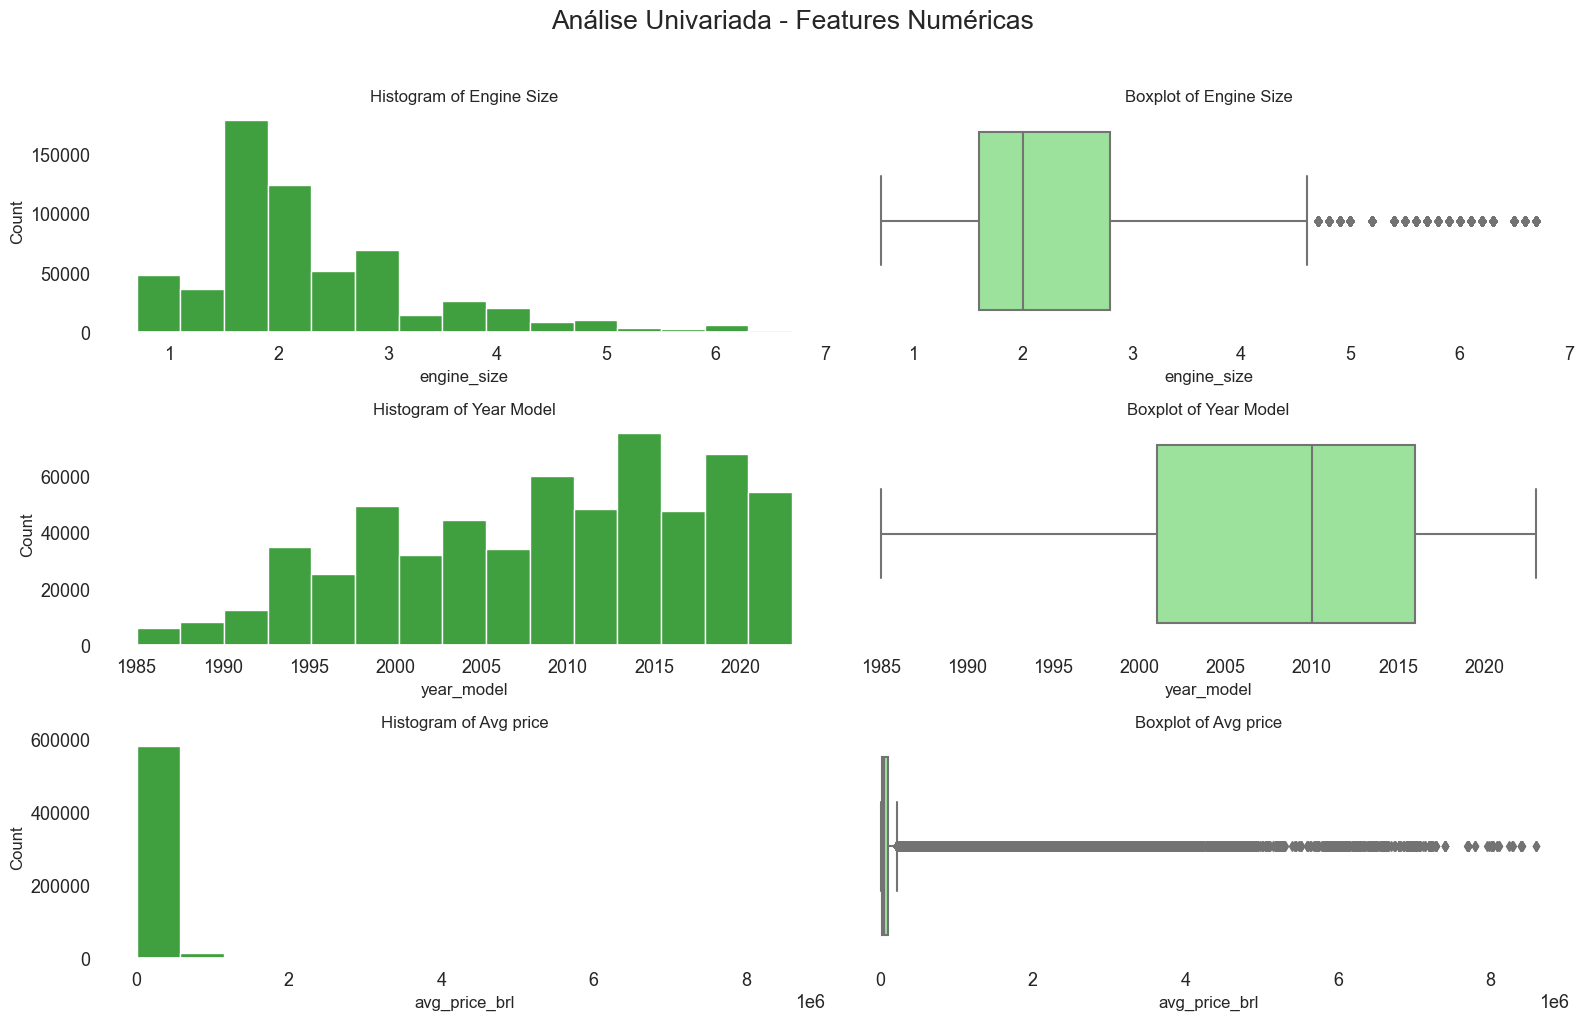

In [7]:
sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':13,'ytick.labelsize':13})
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
fig.suptitle('Análise Univariada - Features Numéricas', fontsize=19, y=1.02)

sns.histplot(df_final.engine_size, ax=axes[0, 0], color='green', bins=15)
axes[0, 0].set_title('Histogram of Engine Size')
sns.boxplot(x=df_final.engine_size, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Boxplot of Engine Size')
sns.histplot(df_final.year_model, ax=axes[1, 0], color='green', bins=15)
axes[1, 0].set_title('Histogram of Year Model')
sns.boxplot(x=df_final.year_model, ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Boxplot of Year Model')

sns.histplot(df_final.avg_price_brl, ax=axes[2, 0], color='green', bins=15)
axes[2, 0].set_title('Histogram of Avg price')
sns.boxplot(x=df_final.avg_price_brl, ax=axes[2, 1], color='lightgreen')
axes[2, 1].set_title('Boxplot of Avg price')


plt.tight_layout()
plt.show()

In [8]:
df_final.avg_price_brl.describe()

count    599004.0000
mean     111580.9137
std      291224.4325
min        1679.0000
25%       20150.0000
50%       42988.5000
75%       96921.2500
max     8600000.0000
Name: avg_price_brl, dtype: float64

In [9]:
# Filtrando outliears da coluna "avg_price_brl" por marcas

df2 = df_final.query('avg_price_brl > 96000')
df2_grouped = df2.groupby('brand')['avg_price_brl'].agg(['count', 'mean'])
df2_grouped = df2_grouped.sort_values(by='count', ascending=False)
df2_grouped.head()

,count,mean
brand,,
Mercedes-Benz,23073,324249.4885
Porsche,13207,604378.8279
BMW,13204,311545.2342
Audi,11326,297976.2457
Land Rover,9921,354936.2988


**Observações:**
_________
- Maior agrupamento de dados proximo a motores 2.0
 ____
- Maior distribuição dos dados entre carros modelos 2000 - 2015
 ____
- Dataset contém outliers, após investigar "avg_price_brl" constatei que são modelos de carros de luxo e decidi manter o dataset, pois a exclusão poderá prejudicar o modelo de realizar previsões para carros de luxo.
___

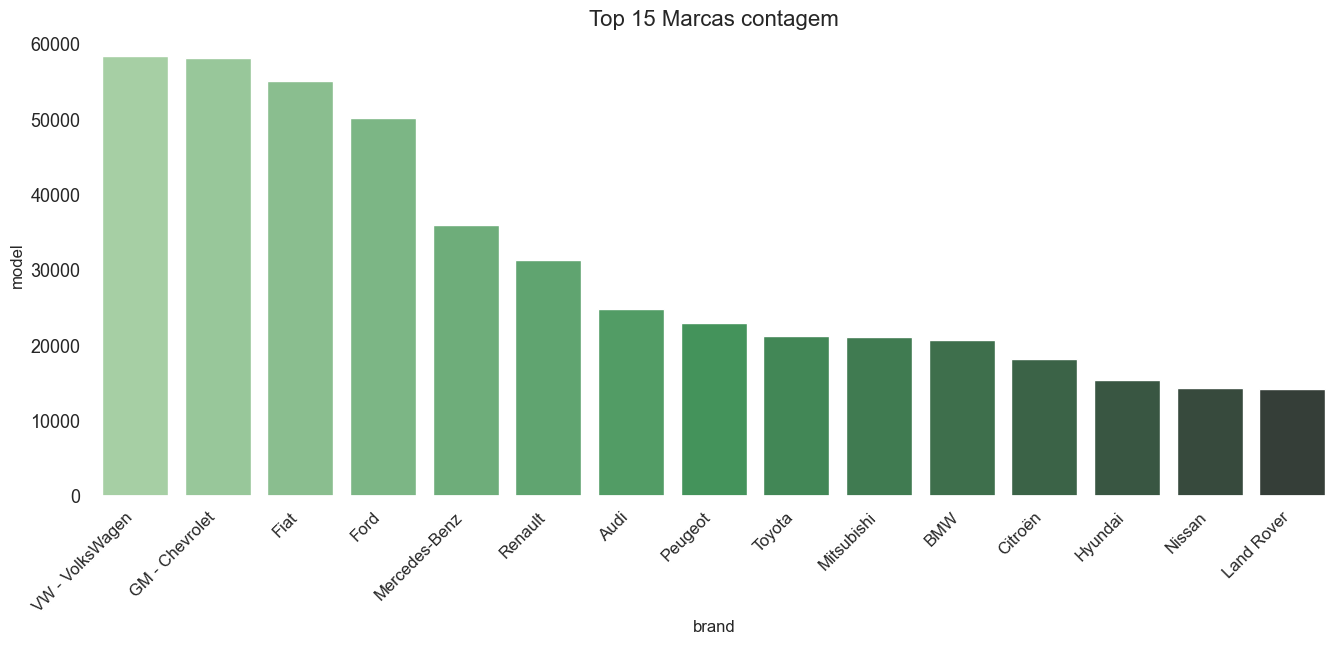

In [10]:
top_brands_mdl = df_final[['brand', 'model']].groupby('brand').count().sort_values(by="model", ascending=False).head(15)
top_brands_mdl = top_brands_mdl.reset_index()
plt.figure(figsize=(16, 6))
sns.barplot(x='brand', y='model', data=top_brands_mdl, palette='Greens_d')
plt.title('Top 15 Marcas contagem', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

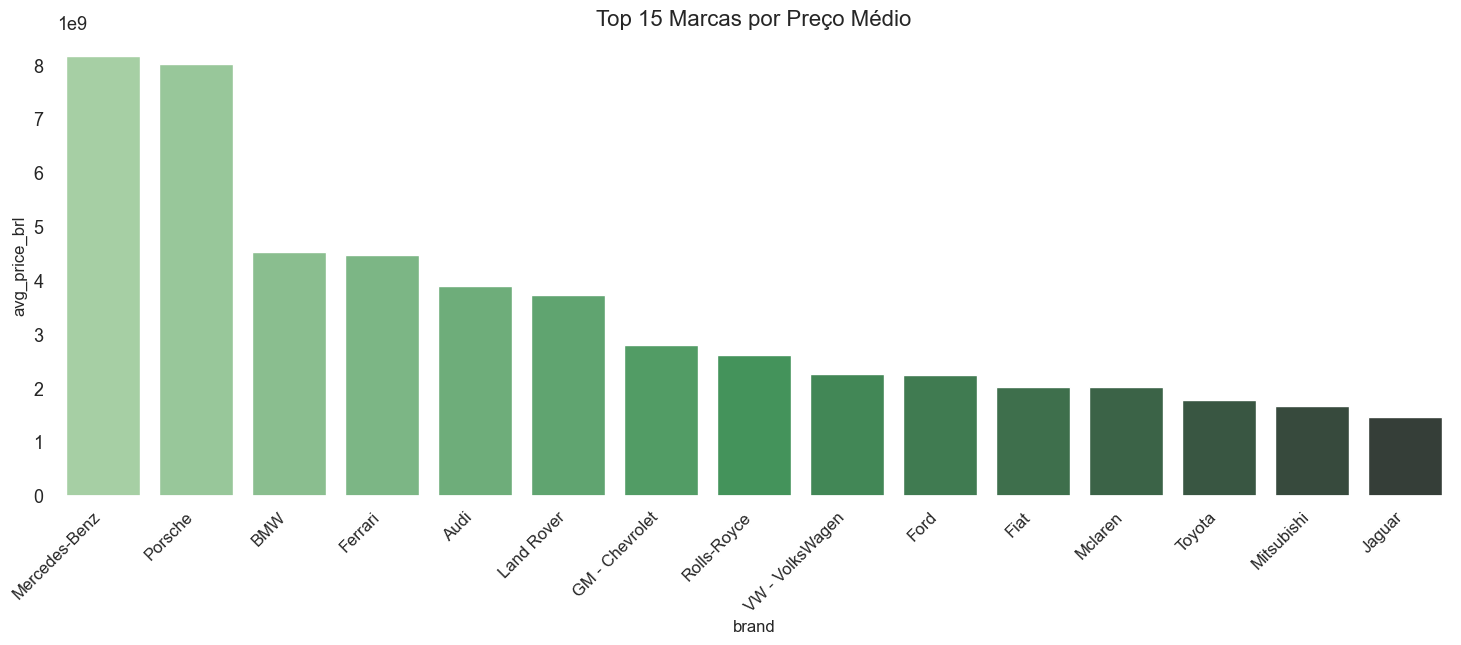

In [11]:
top_brands_avgpr = df_final[['brand', 'avg_price_brl']].groupby('brand').sum().sort_values(by="avg_price_brl", ascending=False).head(15)
top_brands_avgpr = top_brands_avgpr.reset_index()
plt.figure(figsize=(18, 6))
sns.barplot(x='brand', y='avg_price_brl', data=top_brands_avgpr, palette='Greens_d')
plt.title('Top 15 Marcas por Preço Médio', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

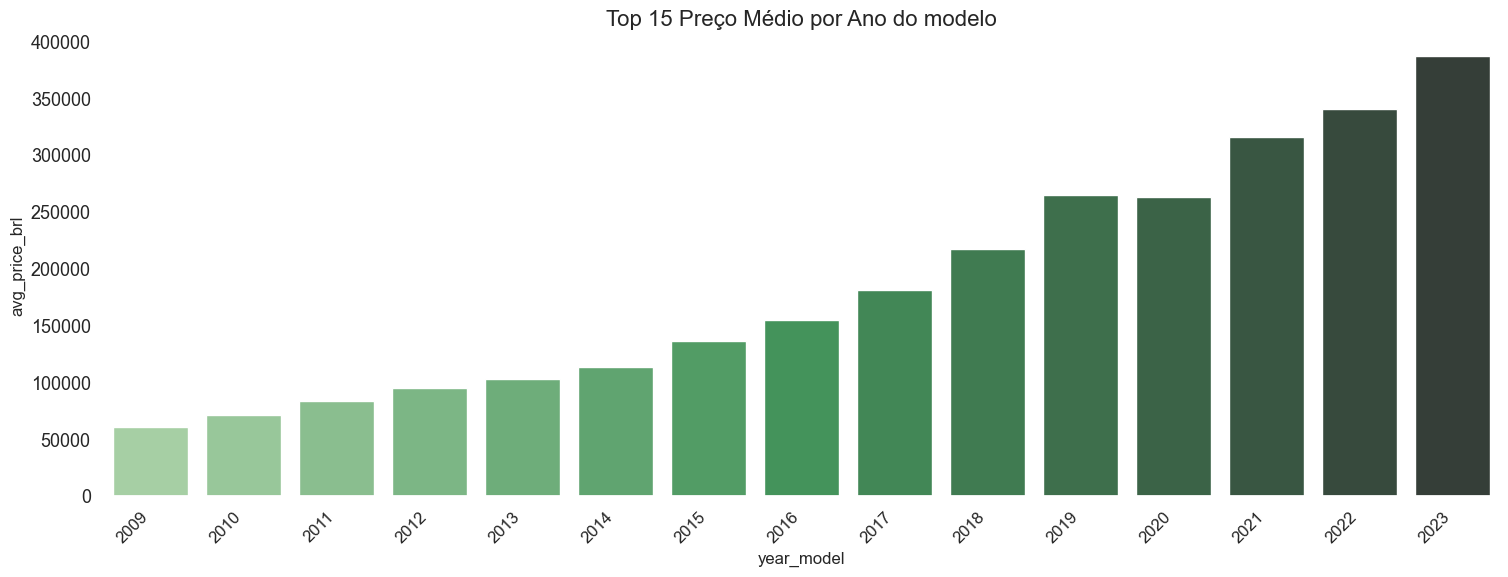

In [12]:
top_brands_avgpr = df_final[['year_model', 'avg_price_brl']].groupby('year_model').mean().sort_values(by="avg_price_brl", ascending=False).head(15)
top_brands_avgpr = top_brands_avgpr.reset_index()
plt.figure(figsize=(18, 6))
sns.barplot(x='year_model', y='avg_price_brl', data=top_brands_avgpr, palette='Greens_d')
plt.title('Top 15 Preço Médio por Ano do modelo', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

 **Observações:**
 ____
- Analisando Marcas por quantidades, vemos que os marcas de populares lideram o ranking
 ____
- Analisando Marcas pela preço médio, vemos que marcas de carros de luxo lideram o ranking
 ____
- Analisando Ano do veículos pelo preço médio, vemos que o valor aumenta proporcional ao ano do carro
___

 # Combustível / preço de carro
 

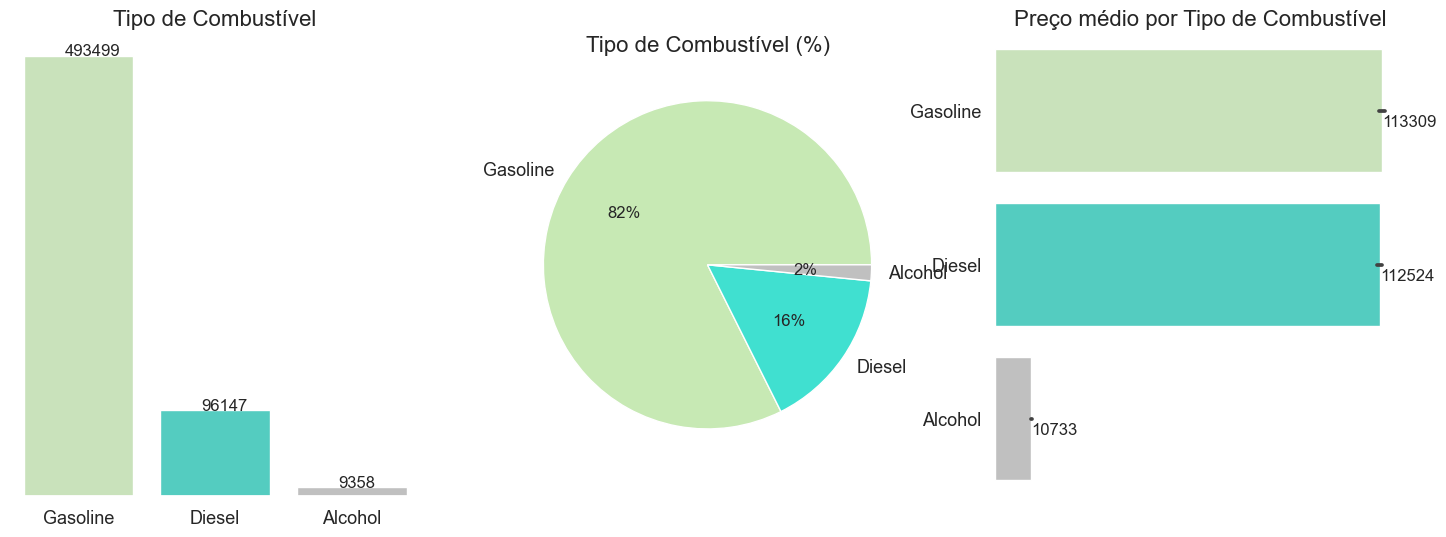

In [13]:
my_col=('#c7e9b4', '#40E0D0', '#C0C0C0')
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title('Tipo de Combustível', fontsize=16)
ax = sns.countplot(x="fuel", palette=my_col, data=df_final)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+60))
plt.xlabel(None), plt.ylabel(None), plt.yticks([])

plt.subplot(1,3,2)
plt.title('Tipo de Combustível (%)', fontsize=16)
df_final['fuel'].value_counts().plot(kind='pie', colors=my_col, legend=None, ylabel='', autopct='%1.0f%%')

plt.subplot(1,3,3)
plt.title('Preço médio por Tipo de Combustível', fontsize=16)
ax = sns.barplot(y="fuel", x='avg_price_brl', palette=my_col, data=df_final)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_width()),  (p.get_x() + p.get_width() + 0.05, p.get_y()+0.5))
plt.xlabel(None), plt.ylabel(None), plt.xticks([])

plt.show()

**Observações:**
_________

- 82% dos carros são a gasolina.

___________

- Analisando preço de carros por tipo de combustivel, vemos que temos quantidade menor quantidade de carros à diesel porem em soma de valores é equivalente aos carros à gasolina
_____

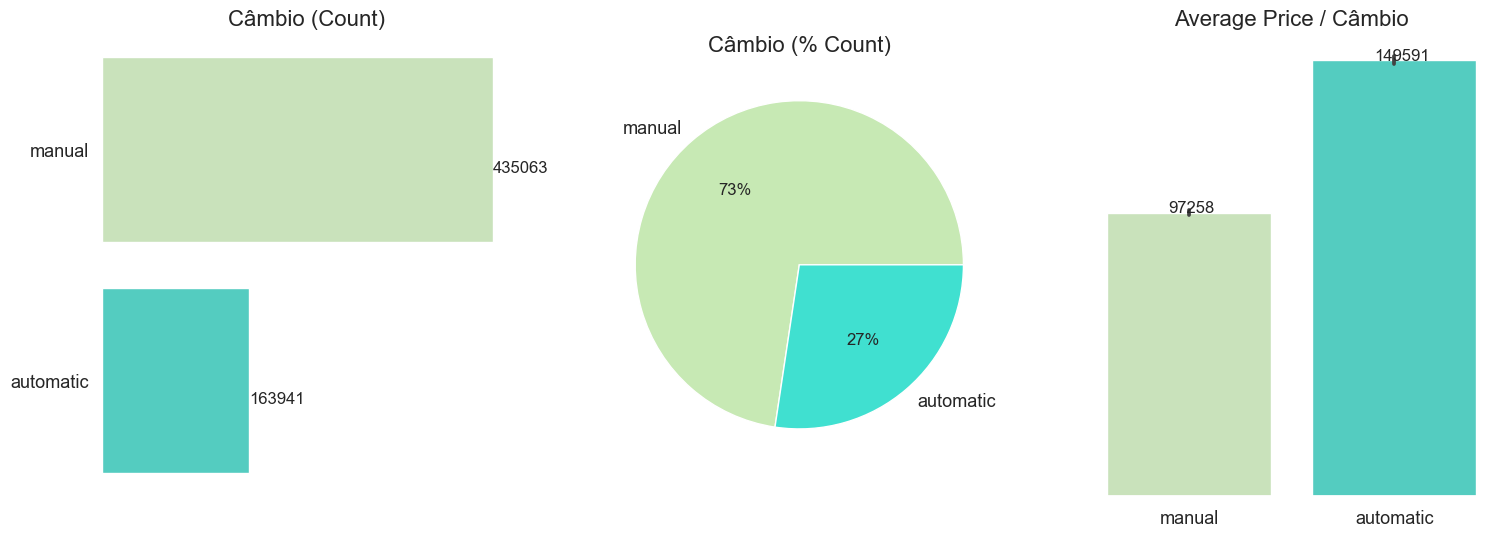

In [14]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title('Câmbio (Count)', fontsize=16)
ax = sns.countplot(y="gear", palette=my_col, data=df_final)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_width()),  (p.get_x() + p.get_width() + 0.05, p.get_y()+0.5))
plt.xlabel(None), plt.ylabel(None), plt.xticks([])

plt.subplot(1,3,2)
plt.title('Câmbio (% Count)', fontsize=16)
df['gear'].value_counts().plot(kind='pie', colors=my_col, legend=None, ylabel='', autopct='%1.0f%%')

plt.subplot(1,3,3)
plt.title('Average Price / Câmbio', fontsize=16)
ax = sns.barplot(x="gear", y='avg_price_brl', palette=my_col, data=df)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+60))
plt.xlabel(None), plt.ylabel(None), plt.yticks([])

plt.show()

**Observações:**
 ____

- Analisando carros por tipo de cambio, vemos que temos quantidade menor quantidade de carros automáticos, porem em valores os carros de cambio automático são aproximadamente 1/3 mais caros do que manual.

# Análise de correlação heatmap

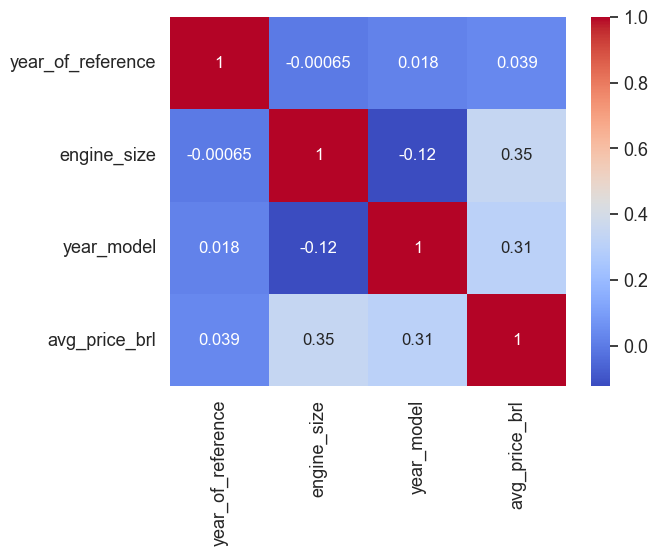

In [15]:
corr_matrix = df_final.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

**Observações:**
 ____

- Correlações moderadas, acima de 0.30, entre as colunas: year_model,engine_size e avg_price; indica uma relação positiva moderada entre as variáveis, onde o aumento em uma variável tende a estar associado ao aumento na outra.

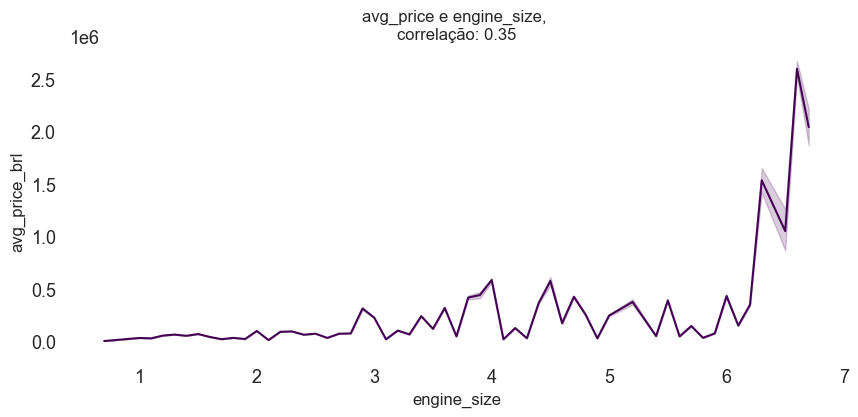

In [16]:
plt.figure(figsize=(10, 4))
engine_correlation = df_final['engine_size'].corr(df_final['avg_price_brl']).round(2)
sns.lineplot(data=df_final, x='engine_size', y='avg_price_brl', color = '#440154')
plt.title(f'avg_price e engine_size, \ncorrelação: {engine_correlation}')
plt.show()

**Observações:**
 ____
 - Carros mais potentes são mais caros.

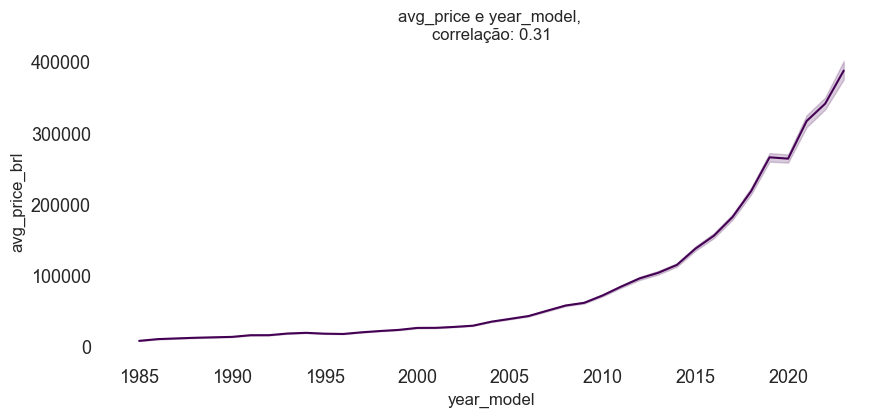

In [17]:
plt.figure(figsize=(10, 4))
year_correlation = df_final['year_model'].corr(df_final['avg_price_brl']).round(2)
#plt.scatter(y=final_df['engine_size'], x=final_df['avg_price_brl'])
sns.lineplot(data=df_final, x='year_model', y='avg_price_brl', color = '#440154')
plt.title(f'avg_price e year_model, \ncorrelação: {year_correlation}')
plt.show()

**Observações:**
 ____

 - Carros mais novos são mais caros.

# 5. Pré-processamento dos Dados 

In [18]:
# Normalização de dados
le = LabelEncoder ()

# Selecionando colunas categoricas
cat_df = df_final.select_dtypes(exclude=["int", "float"])

for i in cat_df:
    cat_df[i] = le.fit_transform(df_final[i])

# Agrupando
num_df = df_final.select_dtypes(include=['int', 'float'])
main_df = pd.concat([num_df, cat_df], axis=1)

In [19]:

X = main_df.drop(columns=["avg_price_brl"])
y = main_df["avg_price_brl"]

# standard scaler
scaler = StandardScaler()
x_scaled=scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(x_scaled ,y, test_size=0.2, random_state=0)

# 6. Machine learning 

- Seleção de modelos adequados.
- Treinamento dos modelos no conjunto de treino.
- Avaliação inicial dos modelos no conjunto de teste (métricas de desempenho).


**Função, treinar e printar principais métricas do modelo escolhido**

In [20]:
model_preds = []

def fit_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = round(r2_score(y_test, y_pred),4)
    adj_r2 = round(1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1),4)
    mse = round(mean_squared_error(y_test, y_pred),4)
    mae = round(mean_absolute_error(y_test, y_pred),4)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
    model_preds.append([model_name, r2, adj_r2, mse, mae, rmse])
    print ("The R-Squared Value (r2) is: ", r2)
    print ("Adjusted R-Squared Value (adj_r2) is: ", adj_r2)
    print("The Mean Squared error (MSE) is: ", mse)
    print("Root Mean Squared Error (RMSE)  is: ", rmse)
    print("Mean Absolute Error (MAE) is: ", mae)

## model evaluation function
def model_eval():
    preds = pd.DataFrame(model_preds)
    preds.columns = ["Mod_Name", "R2 Value", "adj_R2", "MSE", "RMSE", "MAE"]
    return preds.sort_values(by="R2 Value", ascending=False)

#  Validação do Modelo
**Métricas:**
___________

**R-Squared Value (R²):**

 O R², ou coeficiente de determinação, mede a proporção da variância total dos dados dependentes que é explicada pelo modelo. Ele é calculado comparando a soma dos quadrados dos resíduos (SS_res) com a soma total dos quadrados (SS_tot).

Fórmula:
 R^2 = 1 - (SS_res / SS_tot)
 Onde:
 SS_res é a soma dos quadrados dos resíduos: Σ(y_i - ŷ_i)^2
 SS_tot é a soma total dos quadrados: Σ(y_i - ȳ)^2
 
Aplicação:
 Utilizado para avaliar o quão bem o modelo explica a variação nos dados. Um valor próximo de 1 indica
 que o modelo explica a maior parte da variação, enquanto um valor próximo de 0 indica que o modelo
 não explica bem os dados.
_________

**Mean Squared Error (MSE):**
 O MSE é a média dos quadrados das diferenças entre os valores previstos (ŷ_i) e os valores reais (y_i).
 Ele penaliza erros maiores mais severamente devido ao quadrado.

Fórmula:
 MSE = (1/n) * Σ(y_i - ŷ_i)^2
 Onde:
 n é o número de observações
 y_i é o valor real
 ŷ_i é o valor previsto
 
Aplicação:
 Usado para medir a qualidade do modelo; valores menores de MSE indicam um melhor ajuste do modelo aos dados.
_________

**Root Mean Squared Error (RMSE):**
 O RMSE é a raiz quadrada do MSE, o que traz o erro médio de volta à mesma unidade dos dados originais,
 facilitando a interpretação.

 Fórmula:
 RMSE = √[(1/n) * Σ(y_i - ŷ_i)^2]
 Onde:
 n é o número de observações
 y_i é o valor real
 ŷ_i é o valor previsto
 
 Aplicação:
Aplicado para avaliar o erro médio de previsão, sendo mais interpretável que o MSE; quanto menor o RMSE, melhor o modelo.
_________

**Mean Absolute Error (MAE):**
O MAE é a média das diferenças absolutas entre os valores previstos e os valores reais.
 Ele não penaliza grandes erros como o MSE e é linear.

 Fórmula:
 MAE = (1/n) * Σ|y_i - ŷ_i|
 Onde:
 n é o número de observações
 y_i é o valor real
ŷ_i é o valor previsto
 
Aplicação:
 Utilizado para medir o erro médio em termos absolutos, sem considerar a direção dos erros;
 valores menores indicam um modelo mais preciso.
_________


In [21]:
## Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

fit_model(lr_model, "Linear Regression")

The R-Squared Value (r2) is:  0.2594
Adjusted R-Squared Value (adj_r2) is:  0.2594
The Mean Squared error (MSE) is:  64145290156.7556
Root Mean Squared Error (RMSE)  is:  253269.2049
Mean Absolute Error (MAE) is:  102090.8402


In [22]:
## XG Boost
XGB_model = xgb.XGBRFRegressor()
fit_model(XGB_model, "XG Boost")

The R-Squared Value (r2) is:  0.8941
Adjusted R-Squared Value (adj_r2) is:  0.8941
The Mean Squared error (MSE) is:  9172819441.429
Root Mean Squared Error (RMSE)  is:  95774.8372
Mean Absolute Error (MAE) is:  35244.5082


In [23]:
## Random Forest
randfor_model = RandomForestRegressor()
fit_model(randfor_model, "Random Forest Regressor")

The R-Squared Value (r2) is:  0.9973
Adjusted R-Squared Value (adj_r2) is:  0.9973
The Mean Squared error (MSE) is:  233933603.0344
Root Mean Squared Error (RMSE)  is:  15294.8881
Mean Absolute Error (MAE) is:  3788.8063


In [24]:
## Decision Trees
dectree_model = DecisionTreeRegressor()
fit_model(dectree_model, "Decision Tree Regressor")

The R-Squared Value (r2) is:  0.9962
Adjusted R-Squared Value (adj_r2) is:  0.9962
The Mean Squared error (MSE) is:  330695364.0071
Root Mean Squared Error (RMSE)  is:  18185.0313
Mean Absolute Error (MAE) is:  4381.1436


In [25]:
## KNN
knn_model = KNeighborsRegressor(n_neighbors=6)
fit_model(knn_model, "K-Neigbors Regressor")

The R-Squared Value (r2) is:  0.9527
Adjusted R-Squared Value (adj_r2) is:  0.9527
The Mean Squared error (MSE) is:  4096445452.6681
Root Mean Squared Error (RMSE)  is:  64003.48
Mean Absolute Error (MAE) is:  14002.4463


# Resultado Geral 

In [26]:
model_eval()

,Mod_Name,R2 Value,adj_R2,MSE,RMSE,MAE
2,Random Forest Regressor,0.9973,0.9973,233933603.0344,3788.8063,15294.8881
3,Decision Tree Regressor,0.9962,0.9962,330695364.0071,4381.1436,18185.0313
4,K-Neigbors Regressor,0.9527,0.9527,4096445452.6681,14002.4463,64003.4800
1,XG Boost,0.8941,0.8941,9172819441.4290,35244.5082,95774.8372
0,Linear Regression,0.2594,0.2594,64145290156.7556,102090.8402,253269.2049


# Predição vs Real

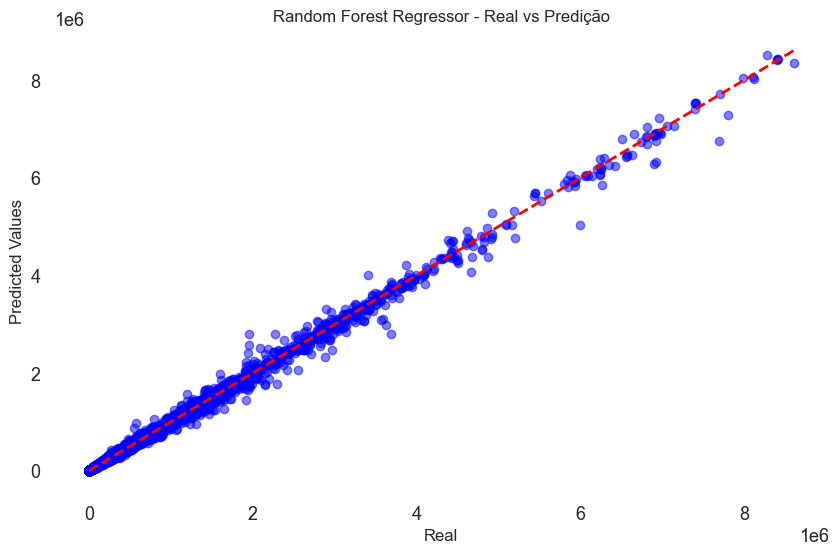

In [27]:
# Função plotar predição
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
             color='red', linestyle='--', linewidth=2, label='Ideal Fit')
    plt.xlabel('Real')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Real vs Predição')
    plt.show()
plot_predictions(y_test, randfor_model.predict(X_test), "Random Forest Regressor")

# 7. Construção do Pipeline de Modelagem
**Configuração do pipeline com os transformadores e o modelo de machine learning**
________
Foi utilizado o pipeline, ColumnTransformer considerando os seguintes transformadores: 
- StandardScaler, para padronização de variáveis numéricas.
- OneHotEncoder, para codificação de variáveis categóricas em representações binárias.
 

In [28]:
# colunas categóricas e numéricas
cat_features = ['month_of_reference', 'fipe_code', 'brand', 'model', 'fuel', 'gear']
num_features = ['year_of_reference', 'engine_size', 'year_model']

# pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Pipeline 
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', RandomForestRegressor(n_estimators=100, random_state=0))])



**Treinamento e Avaliação do Modelo**

In [29]:
# treino e teste
X = df_final.drop(columns=["avg_price_brl"])
y = df_final["avg_price_brl"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Treinar o pipeline com os dados de treino
model_pipeline.fit(X_train, y_train)

# Salvar o pipeline treinado
joblib.dump(model_pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

In [30]:
model_pipeline.score(X_test, y_test)

0.9971671704151038

In [31]:
# Salvar o pipeline treinado
joblib.dump(model_pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

# 8. Teste em Produção com novos Dados Reais

**Objetivo: Preparar os dados para uma nova predição, para Agosto de 2025.**
_____
Seleção de 4 carros populares:
- Gol 2015
- Fiorino 2003
- Celta  2001
- Palio  1999

In [32]:
# Selecionando carros
fipe_codes = ['005397-0', '001004-9', '001001-4', '004202-1']
df_carpop = df.loc[df['fipe_code'].isin(fipe_codes)]
df_carpop = df_carpop.sort_values(by='year_of_reference', ascending=False)
df_carpop = df_carpop.drop_duplicates(subset=['fipe_code']).reset_index(drop=True)
df_carpop

,year_of_reference,month_of_reference,fipe_code,authentication,brand,model,fuel,gear,engine_size,year_model,avg_price_brl
0,2023,January,005397-0,t9d9k3p8f9vt,VW - VolksWagen,Gol Trendline 1.6 T.Flex 8V 5p,Gasoline,manual,1.6000,2015,42226.0000
1,2023,January,001001-4,jlgdlzwg2p0,Fiat,Fiorino Furgão 1.5 mpi / i.e.,Alcohol,manual,1.5000,2003,16557.0000
2,2023,January,004202-1,g9nsh68yrzp,GM - Chevrolet,Celta 1.0/Super/N.Piq.1.0 MPFi VHC 8V 3p,Gasoline,manual,1.0000,2001,13163.0000
3,2023,January,001004-9,cb0sh45rm2gc,Fiat,Palio EX 1.0 mpi 2p,Gasoline,manual,1.0000,1999,8379.0000


In [33]:
df_save = df_carpop.copy()
df_save = df_save.rename(columns={'year_of_reference': 'year_of_reference_2023', 'month_of_reference': 'month_of_reference_2023'})
df_save = df_save[['year_of_reference_2023','month_of_reference_2023']]

# agosto/2025
df_carpop['year_of_reference'] = 2025
df_carpop['month_of_reference'] = 'August'

In [34]:
df_carpop

,year_of_reference,month_of_reference,fipe_code,authentication,brand,model,fuel,gear,engine_size,year_model,avg_price_brl
0,2025,August,005397-0,t9d9k3p8f9vt,VW - VolksWagen,Gol Trendline 1.6 T.Flex 8V 5p,Gasoline,manual,1.6000,2015,42226.0000
1,2025,August,001001-4,jlgdlzwg2p0,Fiat,Fiorino Furgão 1.5 mpi / i.e.,Alcohol,manual,1.5000,2003,16557.0000
2,2025,August,004202-1,g9nsh68yrzp,GM - Chevrolet,Celta 1.0/Super/N.Piq.1.0 MPFi VHC 8V 3p,Gasoline,manual,1.0000,2001,13163.0000
3,2025,August,001004-9,cb0sh45rm2gc,Fiat,Palio EX 1.0 mpi 2p,Gasoline,manual,1.0000,1999,8379.0000


In [35]:
predicted_price = model_pipeline.predict(df_carpop)


In [36]:
# Criando uma nova coluna com a predição
df_carpop['Predicao_2025'] = predicted_price
# Juntando dataframes 
df_final = df_carpop.merge(df_save, how='left', left_index=True, right_index=True)
df_final = df_final[['fipe_code','model','year_model','Predicao_2025']]
df_final['model'] = df_final['model'].str.split().str[0]
df_final

,fipe_code,model,year_model,Predicao_2025
0,005397-0,Gol,2015,42008.1700
1,001001-4,Fiorino,2003,16206.7100
2,004202-1,Celta,2001,13158.6800
3,001004-9,Palio,1999,8479.7000


In [37]:
# Funcao para criar um dataframe com informações do valor médio dos ultimos 5 anos para cada modelo de carro

def temporal_prices(df_base, df_temp):
    
    unique_fipe_codes = df_temp['fipe_code'].unique()
    df_all = pd.DataFrame()
        
    for fipe_code in unique_fipe_codes:
        unique_year_model = df_temp[df_temp['fipe_code'] == fipe_code]['year_model'].max()
        
        # Filtrar df_base para o fipe_code e year_model específicos
        df_filtered = df_base[
            (df_base['fipe_code'] == fipe_code) &
            (df_base['year_model'] == unique_year_model)
        ]
        
        # Agrupar por fipe_code, year_of_reference e year_model, e calcular a média de avg_price_brl
        df_grouped = df_filtered.groupby(['fipe_code', 'year_of_reference', 'year_model'])['avg_price_brl'].mean().reset_index()
        
        # Ordenar por fipe_code, year_model e year_of_reference em ordem decrescente
        df_sorted = df_grouped.sort_values(by=['fipe_code', 'year_model', 'year_of_reference'], ascending=[True, True, False])
        
        # Manter somente os últimos 5 anos para cada fipe_code e year_model
        df_last_5_years = df_sorted.groupby(['fipe_code', 'year_model']).head(10)
        
        # Pivotar o DataFrame para ter ano como colunas e year_model como uma coluna adicional
        df_pivot = df_last_5_years.pivot_table(
            index=['fipe_code', 'year_model'],
            columns='year_of_reference',
            values='avg_price_brl'
        ).reset_index()
        
        # Renomear colunas para o formato desejado
        df_pivot.columns.name = None  # Remove o nome do índice das colunas
        df_pivot.columns = ['fipe_code', 'year_model'] + [f'avg_price_brl_{col}' for col in df_pivot.columns if col not in ['fipe_code', 'year_model']]
        
        # Concatenar o resultado com o DataFrame final
        df_all = pd.concat([df_all, df_pivot], ignore_index=True)
    
    return df_all

In [38]:
df_producao = temporal_prices(df, df_final)

In [42]:
df_producao = df_producao[['avg_price_brl_2021', 'avg_price_brl_2022','avg_price_brl_2023']]
df_producao = df_final.merge(df_producao, how='left', left_index=True, right_index=True)

df_producao = df_producao[['fipe_code', 'model', 'year_model','avg_price_brl_2021', 'avg_price_brl_2022', 'avg_price_brl_2023', 'Predicao_2025']]
df_producao = df_producao.rename(columns={
    'avg_price_brl_2021': 'Valor_2021',
    'avg_price_brl_2022': 'Valor_2022',
    'avg_price_brl_2023': 'Valor_2023'
})


In [43]:
df_producao

,fipe_code,model,year_model,Valor_2021,Valor_2022,Valor_2023,Predicao_2025
0,005397-0,Gol,2015,34625.0833,41276.3333,42226.0000,42008.1700
1,001001-4,Fiorino,2003,13192.4167,15539.1667,16557.0000,16206.7100
2,004202-1,Celta,2001,11269.8333,13034.9167,13163.0000,13158.6800
3,001004-9,Palio,1999,7196.6250,7854.1250,7734.0000,8479.7000


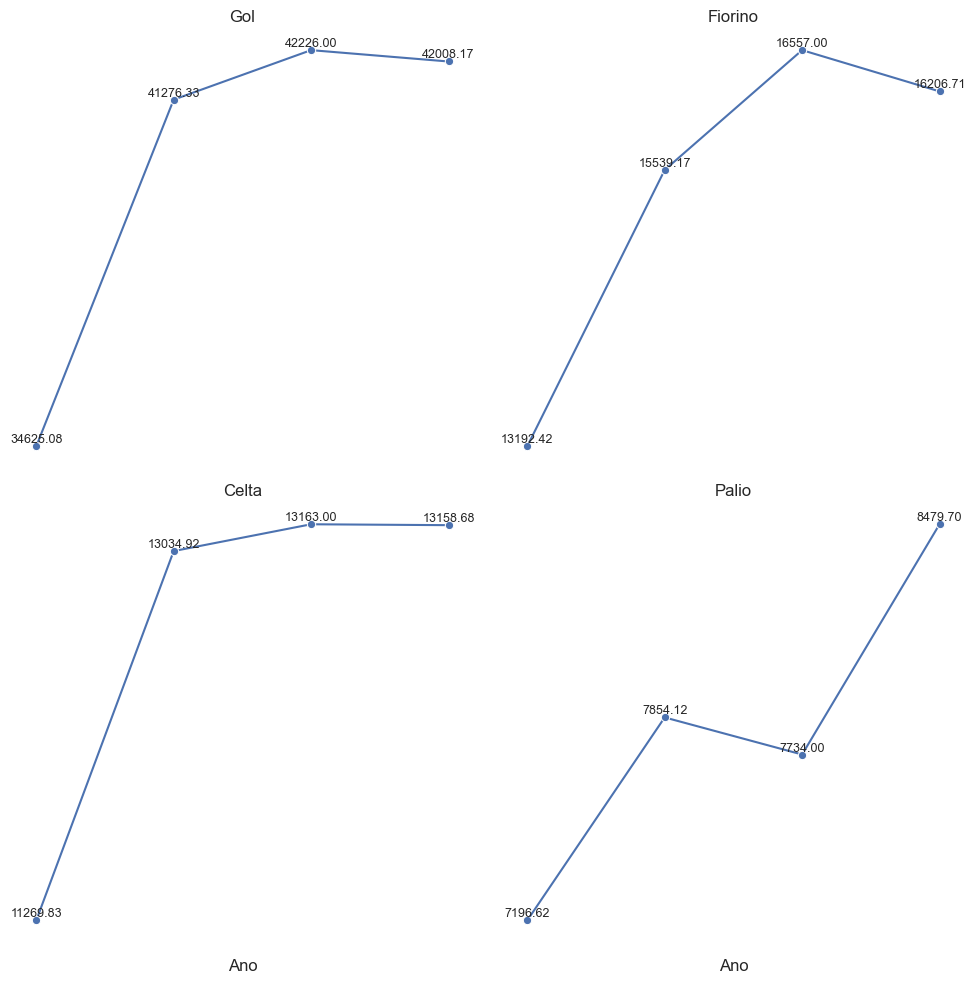

In [45]:
# Reorganizar o DataFrame de formato largo para longo
df_melted = df_producao.melt(id_vars='model', 
                             value_vars=['Valor_2021', 'Valor_2022', 'Valor_2023', 'Predicao_2025'],
                             var_name='Year', value_name='Price')

# Criar o FacetGrid
g = sns.FacetGrid(df_melted, col='model', col_wrap=2, sharey=False, height=5)

# Adicionar o gráfico de linhas a cada subplot
g.map_dataframe(sns.lineplot, x='Year', y='Price', marker='o')

# Adicionar os rótulos aos gráficos
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Ano", "")  # Remover o rótulo do eixo y

# Girar os rótulos dos eixos x em 45 graus e adicionar valores aos pontos
for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks())  # Define os ticks do eixo x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels([])  # Remove os rótulos do eixo y, mas mantém as marcas

    # Adicionar rótulos aos pontos
    for line in ax.get_lines():
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        for i in range(len(x_data)):
            ax.text(x_data[i], y_data[i], f'{y_data[i]:.2f}', 
                    ha='center', va='bottom', fontsize=9)

# Ajustar o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Mostrar o gráfico
plt.show()
